In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork  # Perubahan di sini
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [7]:
# # Prediksi Performa Akademik Mahasiswa Menggunakan Penalaran Probabilistik

## 1. Persiapan Data dan Pemahaman Dataset

# Membuat pemetaan untuk variabel kategorikal
pemetaan = {
    'Gender': {0: 'Laki-laki', 1: 'Perempuan'},
    'Ethnicity': {0: 'Kaukasia', 1: 'Afrika-Amerika', 2: 'Asia', 3: 'Lainnya'},
    'ParentalEducation': {
        0: 'Tidak Sekolah', 1: 'SMA', 2: 'Perguruan Tinggi (Sebagian)', 3: 'Sarjana', 4: 'Pascasarjana'
    },
    'ParentalSupport': {
        0: 'Tidak Ada', 1: 'Rendah', 2: 'Sedang', 3: 'Tinggi', 4: 'Sangat Tinggi'
    },
    'GradeClass': {
        0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'
    },
    'YaTidak': {0: 'Tidak', 1: 'Ya'}
}

# Memuat dataset
data = pd.read_csv('./../Student_performance_data_.csv')

# Menerapkan pemetaan untuk kolom label
data['Gender_Label'] = data['Gender'].map(pemetaan['Gender'])
data['Ethnicity_Label'] = data['Ethnicity'].map(pemetaan['Ethnicity'])
data['ParentalEducation_Label'] = data['ParentalEducation'].map(pemetaan['ParentalEducation'])
data['ParentalSupport_Label'] = data['ParentalSupport'].map(pemetaan['ParentalSupport'])
data['GradeClass_Label'] = data['GradeClass'].map(pemetaan['GradeClass'])

# Untuk variabel biner
for kolom in ['Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']:
    data[f'{kolom}_Label'] = data[kolom].map(pemetaan['YaTidak'])

print("Ukuran dataset:", data.shape)
data.head()

Ukuran dataset: (2392, 25)


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,...,Gender_Label,Ethnicity_Label,ParentalEducation_Label,ParentalSupport_Label,GradeClass_Label,Tutoring_Label,Extracurricular_Label,Sports_Label,Music_Label,Volunteering_Label
0,1001,17,1,0,2,19.833723,7,1,2,0,...,Perempuan,Kaukasia,Perguruan Tinggi (Sebagian),Sedang,C,Ya,Tidak,Tidak,Ya,Tidak
1,1002,18,0,0,1,15.408756,0,0,1,0,...,Laki-laki,Kaukasia,SMA,Rendah,B,Tidak,Tidak,Tidak,Tidak,Tidak
2,1003,15,0,2,3,4.210570,26,0,2,0,...,Laki-laki,Asia,Sarjana,Sedang,F,Tidak,Tidak,Tidak,Tidak,Tidak
3,1004,17,1,0,3,10.028829,14,0,3,1,...,Perempuan,Kaukasia,Sarjana,Tinggi,D,Tidak,Ya,Tidak,Tidak,Tidak
4,1005,17,1,0,2,4.672495,17,1,3,0,...,Perempuan,Kaukasia,Perguruan Tinggi (Sebagian),Tinggi,F,Ya,Tidak,Tidak,Tidak,Tidak


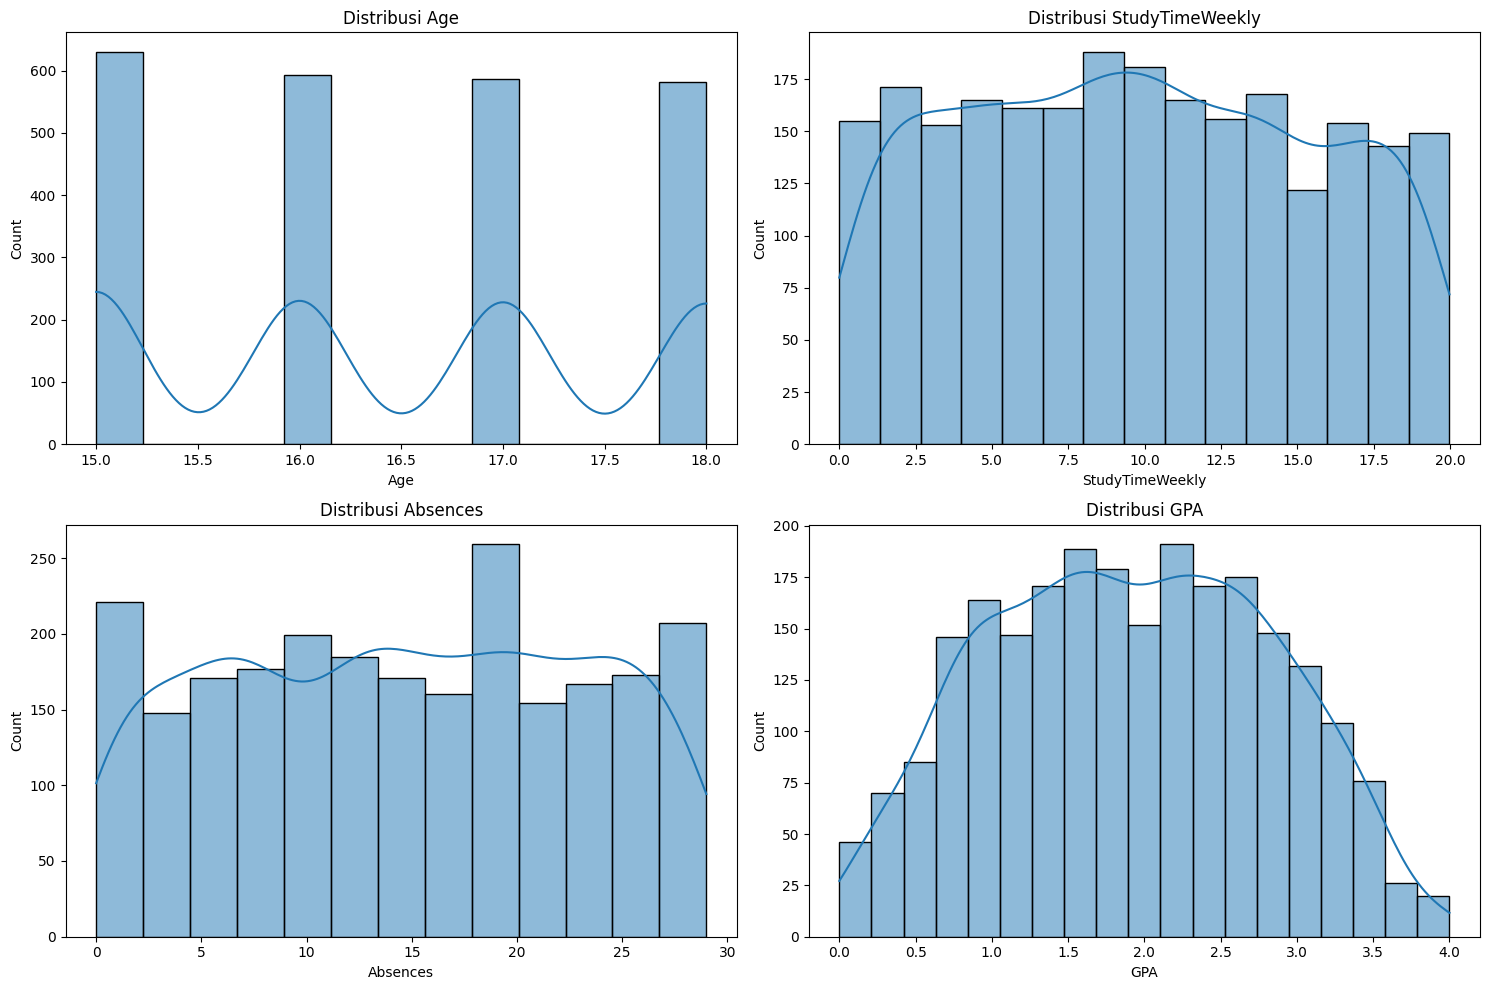

In [4]:
# %%
# Fungsi untuk membuat kategori yang bermakna
def diskritisasi_data(df):
    # Kategori waktu belajar per minggu (jam)
    df['Kategori_Studi'] = pd.cut(df['StudyTimeWeekly'], 
                                 bins=[0, 5, 10, 15, 20, float('inf')],
                                 labels=['0-5 jam', '5-10 jam', '10-15 jam', '15-20 jam', '>20 jam'])
    
    # Kategori absensi
    df['Kategori_Absen'] = pd.cut(df['Absences'],
                                 bins=[0, 5, 10, 15, 20, float('inf')],
                                 labels=['0-5x', '5-10x', '10-15x', '15-20x', '>20x'])
    
    # Kategori IPK sesuai dengan GradeClass
    df['Kategori_IPK'] = pd.cut(df['GPA'],
                                bins=[0, 2.0, 2.5, 3.0, 3.5, 4.0],
                                labels=['F', 'D', 'C', 'B', 'A'])
    
    return df

data = diskritisasi_data(data)

# Visualisasi distribusi data
plt.figure(figsize=(15,10))
for i, kolom in enumerate(['Age', 'StudyTimeWeekly', 'Absences', 'GPA']):
    plt.subplot(2,2,i+1)
    sns.histplot(data[kolom], kde=True)
    plt.title(f'Distribusi {kolom}')
plt.tight_layout()
plt.show()

In [5]:
# %%
# Mendefinisikan struktur jaringan berdasarkan pengetahuan domain
model = BayesianNetwork([
    # Pengaruh demografis
    ('Age', 'StudyTimeWeekly'),
    ('Gender', 'Extracurricular'),
    
    # Pengaruh orang tua
    ('ParentalEducation', 'ParentalSupport'),
    ('ParentalSupport', 'StudyTimeWeekly'),
    ('ParentalSupport', 'Tutoring'),
    
    # Kebiasaan belajar
    ('StudyTimeWeekly', 'GPA'),
    ('Absences', 'GPA'),
    ('Tutoring', 'GPA'),
    
    # Aktivitas ekstrakurikuler
    ('Extracurricular', 'Sports'),
    ('Extracurricular', 'Music'),
    
    # Hasil akademik
    ('GPA', 'GradeClass'),
    ('Sports', 'GradeClass')
])

# Membagi data latih dan uji
data_latih, data_uji = train_test_split(data, test_size=0.2, random_state=42)

# Melatih model
model.fit(data_latih, estimator=MaximumLikelihoodEstimator)

# Membuat inferensi
inferensi = VariableElimination(model)

# Contoh query
hasil = inferensi.query(
    variables=['Kategori_IPK'],
    evidence={'Kategori_Studi': '10-15 jam', 'Kategori_Absen': '5-10x'}
)
print(hasil)

ImportError: BayesianNetwork has been deprecated. Please use DiscreteBayesianNetwork instead.